In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset


In [2]:
# Load the dataset
file_path = '/kaggle/input/train-dataset4/Output.csv'
df = pd.read_csv(file_path)

# Filter out rows where the heading contains the word "map"
df_filtered = df[~df['heading'].str.lower().str.contains(r'\bmap\b')]

# Encode labels
label_encoder = LabelEncoder()
df_filtered['label'] = label_encoder.fit_transform(df_filtered['category'])


/tmp/ipykernel_36/2933081762.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'] = label_encoder.fit_transform(df_filtered['category'])


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['heading'], padding='max_length', truncation=True)

df_filtered['tokenized'] = df_filtered['heading'].apply(lambda x: tokenizer.encode_plus(
    x, 
    max_length=128,  # Set the maximum sequence length
    padding='max_length', 
    truncation=True, 
    return_tensors='pt'
))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/tmp/ipykernel_36/3337633155.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['tokenized'] = df_filtered['heading'].apply(lambda x: tokenizer.encode_plus(


In [4]:
# Defining NewsDataset to input dataset incorporating encodings and labels
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Prepare encodings and labels
encodings = tokenizer(df_filtered['heading'].tolist(), padding=True, truncation=True, max_length=128)
labels = df_filtered['label'].tolist()

# Create Dataset and DataLoader
dataset = NewsDataset(encodings, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [5]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [8]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import numpy as np

# Define the compute_metrics function
def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Define training arguments with best model selection
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",  # Updated to use eval_strategy
    save_strategy="epoch",  # Save model at end of each epoch
    load_best_model_at_end=True,  # Load the best model when training is done
    metric_for_best_model="accuracy",  # Metric to select the best model
    greater_is_better=True  # True because higher accuracy is better
)

# Trainer definition
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Function to compute evaluation metrics
)

# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.731700,0.614707,0.818725
2,0.510100,0.594068,0.852020
3,0.147000,0.626051,0.861981


TrainOutput(global_step=5271, training_loss=0.5513876539980489, metrics={'train_runtime': 19661.5201, 'train_samples_per_second': 2.144, 'train_steps_per_second': 0.268, 'total_flos': 1473302859268608.0, 'train_loss': 0.5513876539980489, 'epoch': 3.0})

In [9]:
import numpy as np
import torch

# Generate predictions
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Compute accuracy
accuracy = np.mean(preds == labels)
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.8620


In [10]:
eval_results = trainer.evaluate()

# Print the accuracy
print(f"Validation Accuracy: {eval_results['eval_accuracy']}")

Validation Accuracy: 0.8619806488332384


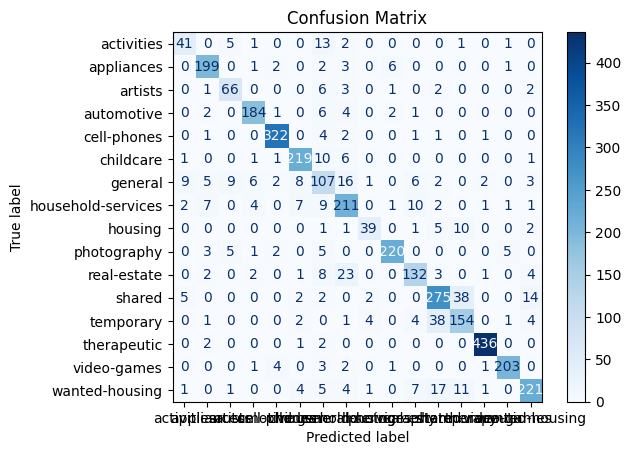

Accuracy: 0.8620
Precision (Weighted): 0.8633
Recall (Weighted): 0.8620
F1-Score (Weighted): 0.8621


In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for the validation dataset
predictions_output = trainer.predict(val_dataset)

# Get predicted labels
preds = np.argmax(predictions_output.predictions, axis=1)

# Get true labels
true_labels = predictions_output.label_ids

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)

# Show the confusion matrix plot
plt.title("Confusion Matrix")
plt.show()

# Calculate performance metrics
accuracy = accuracy_score(true_labels, preds)
precision = precision_score(true_labels, preds, average='weighted')
recall = recall_score(true_labels, preds, average='weighted')
f1 = f1_score(true_labels, preds, average='weighted')

# Print performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")
